# Feed Forward Neural Network Regression with Keras

### Predict fuel efficiency (Copyright 2018 The TensorFlow Authors)

## Imports

In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load data

In [19]:
path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
path

'C:\\Users\\Milton\\.keras\\datasets\\auto-mpg.data'

Import it using pandas

In [20]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_ds = pd.read_csv(path, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)
ds = raw_ds.copy()
ds.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Data cleansing

In [21]:
ds.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [22]:
ds = ds.dropna()

The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:

In [23]:
ds['Origin'] = ds['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [24]:
ds = pd.get_dummies(ds, prefix='', prefix_sep='')
ds.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [25]:
train_ds = ds.sample(frac=0.8,random_state=0)
test_ds = ds.drop(train_ds.index)

## Data analysis

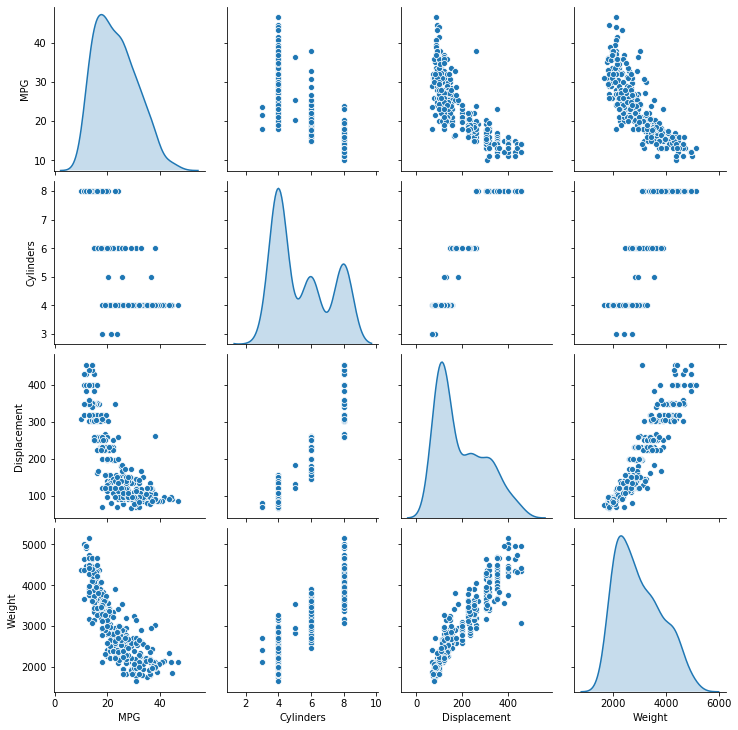

In [26]:
sns.pairplot(train_ds[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde");

Also look at the overall statistics:

In [27]:
stats = train_ds.describe()
stats.pop("MPG")
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Separate target and Normalize

In [28]:
train_labels = train_ds.pop('MPG')
test_labels = test_ds.pop('MPG')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

In [29]:
def normalize(x):
  return (x - stats['mean']) / stats['std']

norm_train_ds = normalize(train_ds)
norm_test_ds = normalize(test_ds)

## Build Model

In [30]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_ds.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  return model

In [31]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [32]:
example = norm_train_ds[:10]
model.predict(example)

array([[ 0.13685301],
       [-0.079862  ],
       [-0.6127915 ],
       [-0.00728262],
       [ 0.47257158],
       [-0.18781018],
       [ 0.5100349 ],
       [ 0.2463918 ],
       [-0.1670011 ],
       [ 0.6574297 ]], dtype=float32)

## Train

In [33]:
res = model.fit(norm_train_ds, train_labels, epochs=1000, validation_split = 0.2, verbose=1)

Epoch 1/1000
8/8 [==============================] - 0s 17ms/step - loss: 561.7635 - mae: 22.5635 - mse: 563.9319 - val_loss: 552.4584 - val_mae: 22.2835 - val_mse: 552.7502
Epoch 2/1000
8/8 [==============================] - 0s 5ms/step - loss: 509.8651 - mae: 21.3566 - mse: 509.7050 - val_loss: 495.3918 - val_mae: 20.9948 - val_mse: 495.6715
Epoch 3/1000
8/8 [==============================] - 0s 5ms/step - loss: 456.0342 - mae: 20.0908 - mse: 456.0397 - val_loss: 435.7334 - val_mae: 19.5315 - val_mse: 435.9909
Epoch 4/1000
8/8 [==============================] - 0s 5ms/step - loss: 398.2597 - mae: 18.6491 - mse: 399.4684 - val_loss: 373.5750 - val_mae: 17.8902 - val_mse: 373.8005
Epoch 5/1000
8/8 [==============================] - 0s 5ms/step - loss: 337.5364 - mae: 17.0271 - mse: 339.7547 - val_loss: 309.4443 - val_mae: 16.0368 - val_mse: 309.6281
Epoch 6/1000
8/8 [==============================] - 0s 5ms/step - loss: 279.6330 - mae: 15.2116 - mse: 278.8871 - val_loss: 244.1107 - val_

In [34]:
hist = pd.DataFrame(res.history)
hist['epoch'] = res.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.027957,0.906072,2.046182,10.335959,2.429495,10.274127,995
996,2.062277,0.919828,2.081796,9.938868,2.393136,9.877982,996
997,2.041592,0.865254,2.042473,10.044293,2.453887,9.982949,997
998,2.221165,0.906658,2.171916,10.009771,2.310941,9.960931,998
999,2.454606,0.953703,2.391497,9.897502,2.335567,9.848608,999


In [35]:
loss, mae, mse = model.evaluate(norm_test_ds, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 9.4829 - mae: 2.3077 - mse: 8.3323
Testing set Mean Abs Error:  2.31 MPG


## Predict

Finally, predict MPG values using data in the testing set:

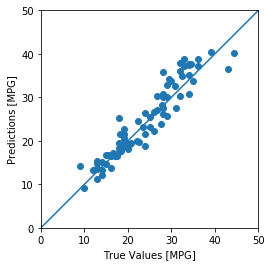

In [36]:
pred = model.predict(norm_test_ds).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, pred)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


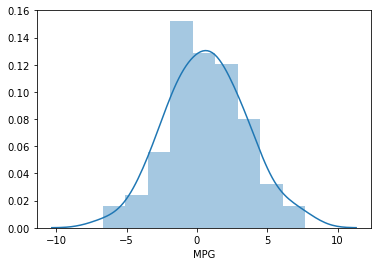

In [37]:
error = pred - test_labels
sns.distplot(error);

## Credits & Links

https://www.tensorflow.org/tutorials/keras/regression